In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

import re

from sklearn.feature_extraction.text import TfidfVectorizer

from collections import Counter

from pprint import pprint

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [2]:
data = pd.read_csv("data/choiceboard_data.csv")[["CPD_Q3"]]
data = data.dropna()
print('There are ' + str(data.shape[0]) + ' rows.')
data.head()

There are 104 rows.


,CPD_Q3
0,I believe self-care to be really important in ...
1,The time spent on my choice of self-care allow...
2,The time spent on my choice of self care affec...
3,It made me more relaxed and less stressed abou...
4,This has been a lifeline because I always felt...


In [3]:
stopwords = set(nltk.corpus.stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess(text):
    # Remove punctuation and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Lowercase
    text = text.lower() 

    # Tokenize
    tokens = word_tokenize(text)  

    # Lemmatize and remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords]

    # Stemming
    tokens = [stemmer.stem(word) for word in tokens] 
    
    # Return preprocessed list of tokens
    return tokens

data['CPD_Q3 Clean'] = data['CPD_Q3'].apply(preprocess)
data['CPD_Q3 Word Count'] = data['CPD_Q3'].apply(lambda x: len(x.split()))
data['CPD_Q3 Clean Word Count'] = data['CPD_Q3 Clean'].apply(lambda x: len(x))
data.head()

,CPD_Q3,CPD_Q3 Clean,CPD_Q3 Word Count,CPD_Q3 Clean Word Count
0,I believe self-care to be really important in ...,"[believ, self, care, realli, import, live, hea...",37,20
1,The time spent on my choice of self-care allow...,"[time, spent, choic, self, care, allow, relax,...",26,15
2,The time spent on my choice of self care affec...,"[time, spent, choic, self, care, affect, posit...",63,30
3,It made me more relaxed and less stressed abou...,"[made, relax, le, stress, upcom, futur, exam, ...",34,13
4,This has been a lifeline because I always felt...,"[lifelin, alway, felt, like, wast, time, walk,...",50,23


In [4]:
data.head()
modelling_data = data[['CPD_Q3 Clean']]
modelling_data.iloc[:,0]

0      [believ, self, care, realli, import, live, hea...
1      [time, spent, choic, self, care, allow, relax,...
2      [time, spent, choic, self, care, affect, posit...
3      [made, relax, le, stress, upcom, futur, exam, ...
4      [lifelin, alway, felt, like, wast, time, walk,...
                             ...                        
102    [way, time, spent, choic, self, care, affect, ...
103    [life, constant, balanc, happi, busi, alway, t...
104    [time, spent, self, care, help, take, mental, ...
106                          [gave, small, break, think]
107                [nice, think, realli, affect, overal]
Name: CPD_Q3 Clean, Length: 104, dtype: object

In [6]:
# Create Corpus
Q3_texts = modelling_data.iloc[:, 0]

# Create Dictionary
id2word = corpora.Dictionary(Q3_texts)


# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in Q3_texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1)]


In [7]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [8]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.051*"time" + 0.026*"care" + 0.026*"feel" + 0.021*"self" + 0.020*"felt" + '
  '0.020*"break" + 0.019*"also" + 0.015*"alway" + 0.015*"posit" + '
  '0.015*"affect"'),
 (1,
  '0.037*"week" + 0.025*"time" + 0.021*"allow" + 0.017*"need" + 0.013*"work" + '
  '0.013*"alway" + 0.013*"care" + 0.013*"new" + 0.013*"bit" + 0.013*"lot"'),
 (2,
  '0.038*"take" + 0.030*"time" + 0.023*"feel" + 0.023*"quarter" + 0.016*"back" '
  '+ 0.016*"like" + 0.016*"care" + 0.016*"studi" + 0.016*"need" + '
  '0.016*"school"'),
 (3,
  '0.063*"time" + 0.054*"care" + 0.049*"self" + 0.022*"help" + 0.020*"take" + '
  '0.019*"feel" + 0.014*"think" + 0.014*"spend" + 0.014*"work" + 0.012*"need"'),
 (4,
  '0.047*"time" + 0.031*"posit" + 0.024*"affect" + 0.024*"like" + 0.016*"valu" '
  '+ 0.016*"away" + 0.016*"felt" + 0.016*"comput" + 0.008*"care" + '
  '0.008*"self"'),
 (5,
  '0.040*"time" + 0.025*"spent" + 0.024*"care" + 0.023*"take" + 0.021*"feel" + '
  '0.019*"self" + 0.018*"also" + 0.018*"help" + 0.018*"like" +

In [10]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=Q3_texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.30679700539538673


In [23]:
# Supporting function
def compute_coherence_values(corpus, dictionary, k, a, b, texts):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [14]:
# Set up for modelling

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 3
max_topics = 9
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.31, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.31, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

In [17]:
# DO NOT RUN THIS CELL UNLESS YOU'RE TUNING LDA MODEL FOR <1 HOUR
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b, texts=Q3_texts)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('./results/lda_tuning_results2.csv', index=False)
    pbar.close()

100%|██████████| 240/240 [32:28<00:00,  8.12s/it]


In [24]:
# Computing coherenence values takes ~11 seconds (Locally for James)
# Computing coherence value with optimal parameters from tuning
cv = compute_coherence_values(corpus=corpus_sets[1], dictionary=id2word, k=8, a='asymmetric', b=0.91, texts=Q3_texts)
print(cv)

0.5905119656511264


In [26]:
# Below results were obtained on February 1, 2024, at ~2:05 AM
# Note: Alpha and Beta columns are STRING values
results = pd.read_csv("results/lda_tuning_results2.csv")
results.sort_values(by=['Coherence'], ascending=False).head()

,Validation_Set,Topics,Alpha,Beta,Coherence
253,100% Corpus,8,asymmetric,0.9099999999999999,0.590512
120,75% Corpus,8,0.61,0.61,0.580329
113,75% Corpus,7,asymmetric,0.9099999999999999,0.568403
93,75% Corpus,6,asymmetric,0.9099999999999999,0.560373
124,75% Corpus,8,0.9099999999999999,0.61,0.548915


**Next steps: organize work above with more comments, documentation, etc.; create better visualizations below**

Text(0, 0.5, 'Coherence Score')

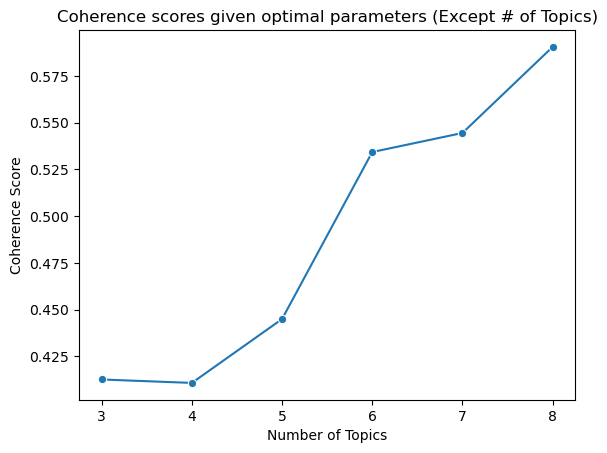

In [25]:
coherences_with_optimal_vs_a_b = results[(results["Alpha"] == "asymmetric") & (results["Validation_Set"] == "100% Corpus") & (results["Beta"].str.contains("0.909"))]


sns.lineplot(data=coherences_with_optimal_vs_a_b, x='Topics', y='Coherence', marker='o')

plt.title("Coherence scores given optimal parameters (Except # of Topics)")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")